In [4]:
%load_ext autoreload
%autoreload 2
%config Application.log_level="INFO"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os, shutil
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
import pdb
import matplotlib.pyplot as plt

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from head.metrics import euclidean_dist
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.acquisition.monte_carlo import qUpperConfidenceBound, qExpectedImprovement
from botorch.acquisition.objective import LinearMCObjective
from matplotlib.cm import ScalarMappable

N_UVVIS_SAMPLES = 15
N_SAS_SAMPLES = 100
NUM_GRID_PERDIM = 100
BATCH_SIZE = 8
N_ITERATIONS = 10
NUM_RESTARTS = 64 
RAW_SAMPLES = 1024
N_INIT_SAMPLES = 8
NUM_FILTERS = 5

R_mu = 20
R_sigma = 1e-2
SHAPE_PARAM = 0.2
SPECTRA = 'saxs'

expt = {}
EXPT_ID = 0

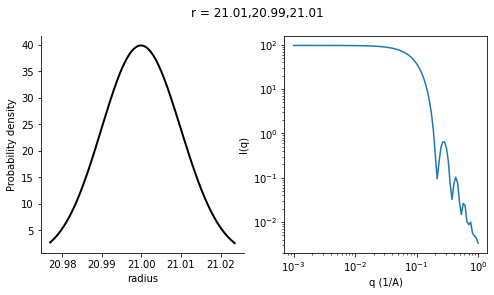

In [6]:
sim = head.EmulatorMultiShape()
sim.make_structure(r_mu=R_mu,r_sigma=R_sigma)

fig, axs = plt.subplots(1,2,figsize=(4*2,4))

sim.plot_radii(axs[0])
axs[0].set_xlabel('radius')
axs[0].set_ylabel('Probability density')

if SPECTRA=='saxs':
    xt, yt = sim.get_saxs(shape_param = SHAPE_PARAM, n_samples=N_SAS_SAMPLES)
    axs[1].loglog(xt, yt)
    plt.setp(axs[1], xlabel='q (1/A)', ylabel='I(q)')
elif SPECTRA=='uvvis':
    xt, yt = sim.get_uvvis(shape_param = 0.67, n_samples=N_UVVIS_SAMPLES)
    axs[1].plot(xt, yt)
    plt.setp(axs[1], xlabel='wavelength (nm))', ylabel=r'I($\lambda$)')
    
fig.suptitle('r = '+','.join('%.2f'%i for i in sim.radii))
plt.show()

In [7]:
# define search space
r_mu = [5,50]
r_sigma = [1e-4,1]
shape_param = [0,1]
bounds = torch.tensor((r_mu, r_sigma, shape_param)).T.to(**tkwargs)

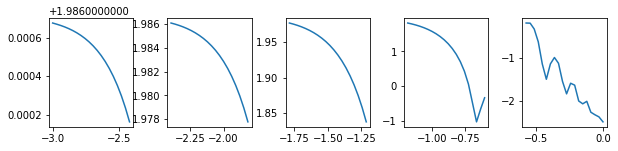

In [8]:
from head import SymmetricMatrices
if SPECTRA=='saxs':
    M = SymmetricMatrices(np.log10(xt), np.log10(yt) , 
                          num_filters = NUM_FILTERS)
else:
    M = SymmetricMatrices(xt, yt , 
                      num_filters = NUM_FILTERS)   
    
M.plot_filters()
def sym_dist(query):
    return -M.distance(query)

In [9]:
def oracle(x):
    """Scoring function at a given input location
    Uses the simulator sim to generate response spectra at a given locations
    and return a similarity score to target spectra
    """
    global EXPT_ID
    x_np = x.cpu().numpy()    
    sim.make_structure(r_mu=x_np[0],
                       r_sigma=x_np[1])
    if SPECTRA=='saxs':
        xi, yi = sim.get_saxs(shape_param = x_np[2], 
                              n_samples=N_SAS_SAMPLES)
        #dist = euclidean_dist(np.log10(yi),np.log10(yt))
        dist = sym_dist(np.log10(yi))
    elif SPECTRA=='uvvis':
        xi, yi = sim.get_uvvis(shape_param = x_np[2], 
                               n_samples=N_UVVIS_SAMPLES)
        #dist = euclidean_dist(yi,yt)
        dist = sym_dist(yi)
        
    expt[EXPT_ID] = [xi, yi, dist]
    EXPT_ID += 1
    
    return torch.tensor([dist])

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0).to(**tkwargs)

In [10]:
from botorch.utils.sampling import draw_sobol_samples

def draw_random_batch(n_samples=6):
    train_x = draw_sobol_samples(
        bounds=bounds,n=1, q=n_samples, 
        seed=torch.randint(2021, (1,)).item()
    ).squeeze(0)
    train_obj = batch_oracle(train_x)
    return train_x, train_obj


train_x, train_obj = draw_random_batch(n_samples=N_INIT_SAMPLES)
print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)
for i in range(N_INIT_SAMPLES):
    print('%d\t%s\t%s'%(i, train_x[i,...].numpy(), train_obj[i,...].numpy()))

Generated 8 samples randomly torch.Size([8, 3]) torch.Size([8, 1])
0	[38.95594001  0.15500129  0.6513381 ]	[-0.2618354]
1	[2.95325243e+01 1.29381183e-01 5.19407354e-03]	[-0.30893475]
2	[46.26395375  0.68762399  0.17803632]	[-0.3406064]
3	[47.15740561  0.34453981  0.6767    ]	[-0.18795639]
4	[37.97258586  0.32020427  0.45573258]	[-0.45767372]
5	[46.3018024   0.29158918  0.0866807 ]	[-0.34082922]
6	[34.43219602  0.96862421  0.80820554]	[-0.27426084]
7	[1.86007403e+01 7.45161807e-01 8.89031403e-03]	[-0.06744945]


In [11]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

In [12]:
from botorch.optim.optimize import optimize_acqf

def selector(f, q = BATCH_SIZE):
    new_x, _ = optimize_acqf(
        acq_function=f,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, 
        sequential=False,
    )
    new_obj = batch_oracle(new_x)
    return new_x, new_obj

In [13]:
torch.manual_seed(2021)
import pdb

# run N_ITERATIONS rounds of BayesOpt after the initial random batch
print('Sampled ID \t Locations \t Objectives')
for iteration in range(1, N_ITERATIONS + 1):    
    print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition module
    #acquisition = qUpperConfidenceBound(model, beta=0.1)
    best_f = train_obj.max(axis=0).values
    acquisition = qExpectedImprovement(model, best_f = sym_dist(yt))
    
    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)
    for i in range(BATCH_SIZE):
        print('%d\t%s\t%s'%(i, new_x[i,...].numpy(), new_obj[i,...].numpy()))

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # re-initialize
    mll, model = initialize_model(train_x, train_obj)

Sampled ID 	 Locations 	 Objectives
Iteration : 1/10
0	[41.50006464  0.84603248  0.41067986]	[-0.32696326]
1	[5.1735305  0.63581739 0.89936573]	[-0.19111312]
2	[18.59644929  0.72865204  0.19447966]	[-0.07768951]
3	[18.7152007   0.84878191  0.        ]	[-0.11112747]
4	[18.47222725  0.8626054   0.        ]	[-0.14790835]
5	[49.99593594  0.99840045  0.1326614 ]	[-0.35793224]
6	[18.58101703  0.56787225  0.        ]	[-0.07576754]
7	[47.54877586  0.28616763  0.88762159]	[-0.18060678]
Iteration : 2/10
0	[22.47620625  0.18491453  0.31410599]	[-0.17187493]
1	[18.58708796  0.66939557  0.06998615]	[-0.08038136]
2	[18.72203602  0.57079578  0.1707669 ]	[-0.06230902]
3	[23.15475096  0.41871558  0.38557074]	[-0.25722872]
4	[3.62888371e+01 9.99999975e-05 1.00000000e+00]	[-0.32571963]
5	[23.49750169  0.4330999   0.23112635]	[-0.23928254]
6	[18.66942138  0.64708285  0.        ]	[-0.11031968]
7	[35.30693345  1.          0.        ]	[-0.36872339]
Iteration : 3/10
0	[44.05789504  0.70081123  0.7961087 ]	[-0

In [14]:
# obtain best sample and corresponding objective
from botorch.acquisition import PosteriorMean

print('Actual target : ', [R_mu, R_sigma, SHAPE_PARAM])
opt_x, opt_obj = selector(PosteriorMean(model), q=1)
opt_x = opt_x.cpu().numpy().squeeze()
print('Optimal location: ',opt_x,
      '\nOptimal model scores: ', opt_obj.numpy())

Actual target :  [20, 0.01, 0.2]
Optimal location:  [19.49202432  0.26890647  0.15640339] 
Optimal model scores:  [[-0.04219123]]


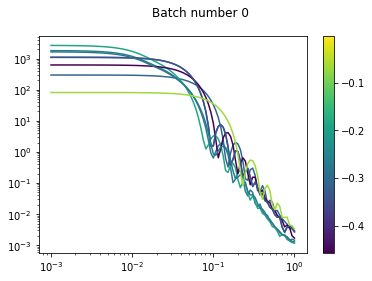

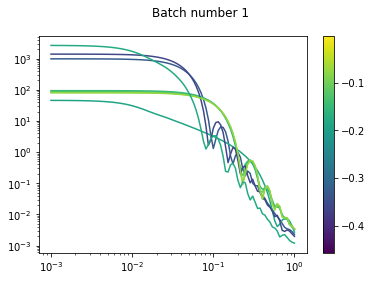

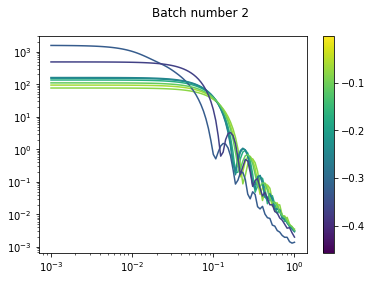

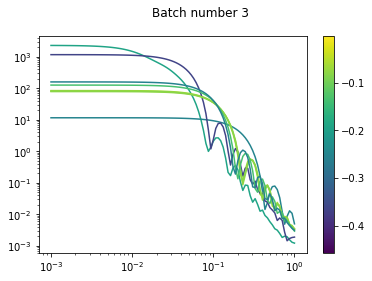

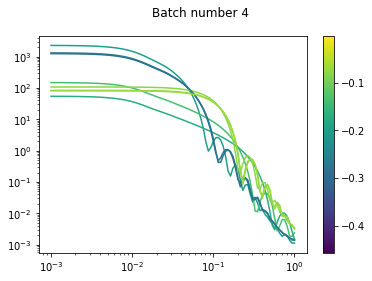

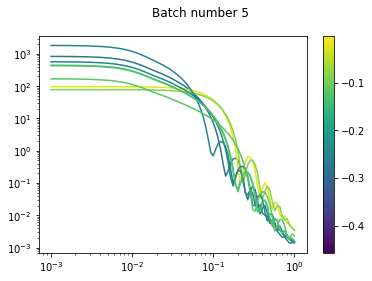

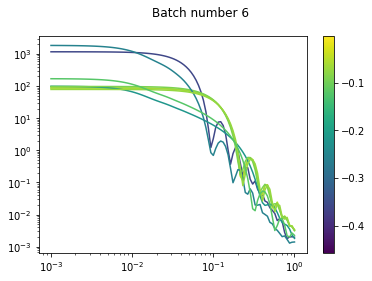

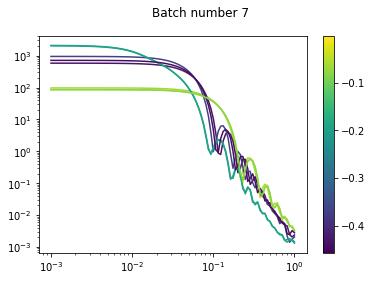

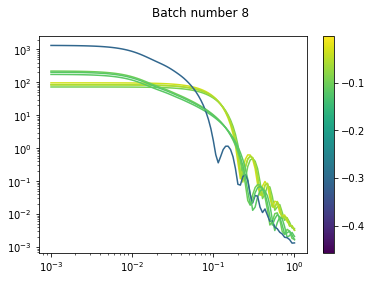

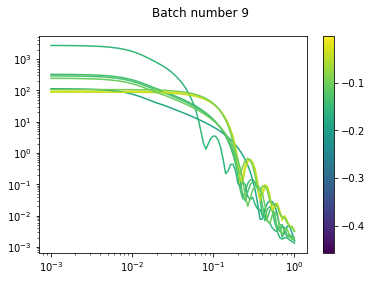

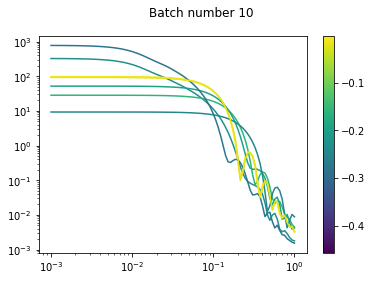

In [15]:
from matplotlib import cm
from matplotlib.colors import Normalize

all_scores = [v[2] for _, v in expt.items()]
norm = Normalize(vmin=min(all_scores), vmax=max(all_scores))
cmap = cm.get_cmap('viridis')
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

batch_number = torch.cat(
    [torch.zeros(N_INIT_SAMPLES), 
     torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

for b in np.unique(batch_number):
    fig, ax = plt.subplots(1,1)
    fig.suptitle('Batch number %d'%b)
    for i in np.argwhere(batch_number==b).squeeze():
        if SPECTRA=='uvvis':
            ax.plot(expt[i][0], expt[i][1], 
                    color=cmap(norm(expt[i][2])))
        elif SPECTRA=='saxs':
            ax.loglog(expt[i][0], expt[i][1],
                      color=cmap(norm(expt[i][2])))
    cbar = fig.colorbar(mappable,ax=ax)
    plt.show()

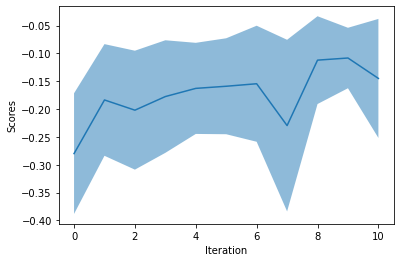

In [16]:
plot_scores = []
for b in np.unique(batch_number):
    scores = np.asarray(all_scores)[np.argwhere(batch_number==b)]
    mu, std = scores.mean(), scores.std()
    plot_scores.append([mu, mu+std, mu-std])
    
plot_scores = np.asarray(plot_scores)
fig, ax = plt.subplots()
ax.fill_between(np.unique(batch_number), y1=plot_scores[:,1], y2=plot_scores[:,2], alpha=0.5)
ax.plot(np.unique(batch_number), plot_scores[:,0])
ax.set_xlabel('Iteration')
ax.set_ylabel('Scores')
plt.show()